In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from keras import datasets, layers, models
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation , DepthwiseConv2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D,  GlobalAveragePooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [2]:
data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)
train_data, valid_data = data['train'], data['validation']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/160px-v2/1.0.0.incompleteVS6VWW/imagenette-train.tfrecord*...:   0%…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/160px-v2/1.0.0.incompleteVS6VWW/imagenette-validation.tfrecord*...:…

Dataset imagenette downloaded and prepared to ~/tensorflow_datasets/imagenette/160px-v2/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_dataset = train_data.map(
    lambda image, label: (tf.image.resize(image, (128, 128)), label))

validation_dataset = valid_data.map(
    lambda image, label: (tf.image.resize(image, (128, 128)), label)
)

In [4]:
num_train = train_dataset.__len__().numpy()
num_val = validation_dataset.__len__().numpy()

num_classes = info.features['label'].num_classes
print('Total number of classes in dataset: ', num_classes)

print('Number of training samples: ', num_train)
print('Number of validation samples: ', num_val)

Total number of classes in dataset:  10
Number of training samples:  9469
Number of validation samples:  3925


In [5]:
get_label_name = info.features['label'].int2str

text_labels = [get_label_name(i) for i in range(num_classes)]
for idx,i in enumerate(text_labels):
    print('Label: {} , Name: {}'.format(idx, i))

Label: 0 , Name: n01440764
Label: 1 , Name: n02102040
Label: 2 , Name: n02979186
Label: 3 , Name: n03000684
Label: 4 , Name: n03028079
Label: 5 , Name: n03394916
Label: 6 , Name: n03417042
Label: 7 , Name: n03425413
Label: 8 , Name: n03445777
Label: 9 , Name: n03888257


In [6]:
X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))


X_valid = list(map(lambda x: x[0], validation_dataset))
y_valid = list(map(lambda x: x[1], validation_dataset))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)


In [7]:
train_len = info.splits['train'].num_examples
validation_len = info.splits['validation'].num_examples

print('Train size: {}'.format(train_len))
print('Validation size: {}'.format(validation_len))

Train size: 9469
Validation size: 3925


In [8]:
print('Y Train shape: {}'.format(y_train.shape))
print('Y Validation shape: {}'.format(y_valid.shape))

Y Train shape: (9469, 10)
Y Validation shape: (3925, 10)


In [9]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      height_shift_range=0.3)

valid_datagen = ImageDataGenerator(
      rescale=1./255)

train_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_train), y=np.array(y_train), image_data_generator=train_datagen,batch_size=32
)

valid_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_valid), y=np.array(y_valid), image_data_generator=valid_datagen,batch_size=32
)

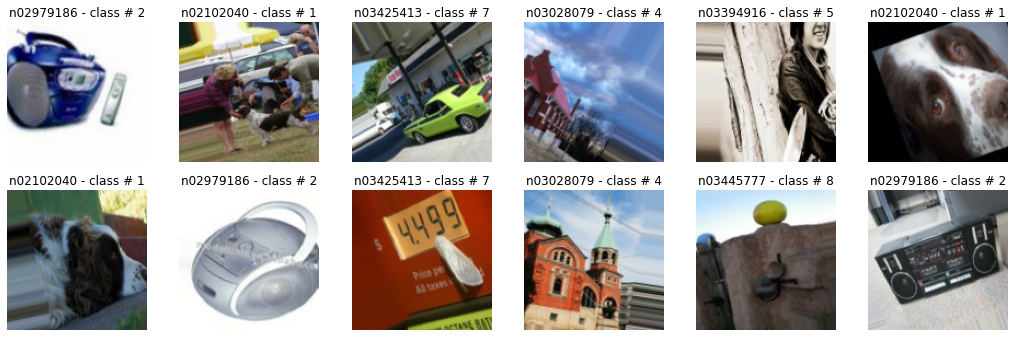

In [10]:
plt.figure(figsize=(18, 18))

num = 0

for i in range(0, 12):
    image,label = next(iter(train_data))
    ax = plt.subplot(6, 6, num + 1)
    plt.imshow(image[0])
    plt.title(str(get_label_name(np.argmax(label))) + ' - class # ' + str(np.argmax(label)))
    plt.axis("off")
    num += 1


In [10]:
def create_MobileNet_model(input_shape, alpha, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(int(alpha*32), kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(int(alpha*64),(1, 1), (1, 1) ,x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(int(alpha*128),(1, 1), (1, 1) ,x)
    
    # print('layer 4 input', x.shape)
    # #4th layer (Conv dw/s1) + (Conv /s1)
    # x = DepthWiseConv((3,3), (1,1), x)
    # x = PointWiseConv(128,(1, 1), (1, 1) ,x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(int(alpha*256),(1, 1), (1, 1) ,x)

    # print('layer 6 input', x.shape)
    # #6th layer (Conv dw/s1) + (Conv /s1)
    # x = DepthWiseConv((3,3), (1,1), x)
    # x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(int(alpha*512),(1, 1), (1, 1) ,x)

    # print('layer 8 stack input', x.shape)
    # #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    # for _ in range(5):
    #   x = DepthWiseConv((3,3), (1,1), x)
    #   x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(int(alpha*1024),(1, 1), (1, 1) ,x)

    x = Dropout(0.2)(x)

    # print('layer 10 input', x.shape)
    # #10th layer (Conv dw/s2) + (Conv /s1)
    # x = DepthWiseConv((3,3), (1,1), x)
    # x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    x = GlobalAveragePooling2D()(x) 

    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    #x = Flatten()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='mobilenet')

    return model    

In [11]:
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [12]:
def PointWiseConv(filters,kernal_size, stride, x):
    result = Conv2D(filters, kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [13]:
MobileNet = create_MobileNet_model((128,128,3),0.250,10)
MobileNet.summary()


layer 1 input (128, 128, 3)
layer 2 input (None, 64, 64, 8)
layer 3 input (None, 64, 64, 16)
layer 5 input (None, 32, 32, 32)
layer 7 input (None, 16, 16, 64)
layer 9 input (None, 8, 8, 128)
Avg Pooling input (None, 4, 4, 256)
Flatten input (None, 256)
Dense 12 input (None, 256)
out (None, 10)
Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         216       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                          

In [14]:
# MobileNet.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# MobileNet.fit(train_data, epochs=20, validation_data=valid_data, verbose=1)

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_filepath = './tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')

history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

MobileNet.load_weights(checkpoint_filepath)


Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.9127 - accuracy: 0.3282
Epoch 1: saving model to ./tmp/checkpoint
296/296 [==============================] - 117s 389ms/step - loss: 1.9127 - accuracy: 0.3282 - val_loss: 3.6630 - val_accuracy: 0.0994
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.6440 - accuracy: 0.4386
Epoch 2: saving model to ./tmp/checkpoint
296/296 [==============================] - 115s 389ms/step - loss: 1.6440 - accuracy: 0.4386 - val_loss: 1.8202 - val_accuracy: 0.3674
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.5173 - accuracy: 0.4922
Epoch 3: saving model to ./tmp/checkpoint
296/296 [==============================] - 115s 388ms/step - loss: 1.5173 - accuracy: 0.4922 - val_loss: 1.7117 - val_accuracy: 0.4217
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.4311 - accuracy: 0.5234
Epoch 4: saving model to ./tmp/checkpoint
296/296 [==============================] - 

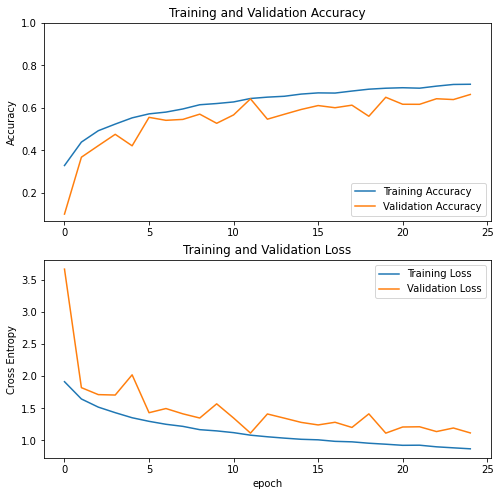

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
!rm -rf ./tmp/checkpoint

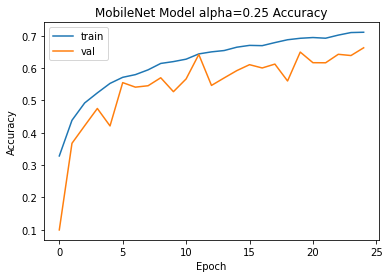

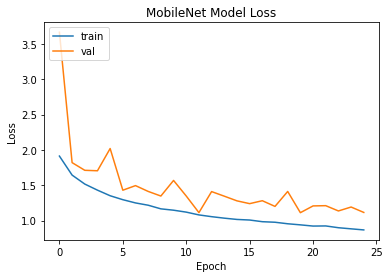

run timing - 88*25s 


In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNet Model alpha=0.25 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("run timing - 88*25s ")